In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy
import scipy.linalg
import scipy.signal
import os
# helpers.py is one level up in the directory structure so we need to tell Python were to find it
import sys
sys.path.append("../../")
import helpers
local_data_folder = os.path.join(helpers.dataset_folder, "week3", "inpainting")

# Pull-Push algorithm

The Pull-Push algorithm is a simple inpainting technique that fills missing part of an image by propagating mean (average) values from neighboring valid regions. The algorithm proceeds in two phases. First, an image pyramid is build by aggregating valid information from the image (pull). Second, the information from the top of the pyramid is propagated down and interpolated into the previously empty bins (push). This results in each image pixel receiving the information from an image area proportional to the size of the hole as larger holes will generally be filled in higher levels of the pull-push pyramid representing mean of a larger portion of the image. While the technique cannot resolve any higher-order statistical properties (gradients, curvatures,...), it provides a visually continuous transition between the original image content and the smooth inpainted regions.

## Exercise 4 (3 points)

First, we will implement a step of the pull phase which generates a new image of half the original size.

Implement a function that aggregates information from an image $\mathbf{I^i} \in \mathcal{R}^{H \times W\times 3}$ into a new image $\mathbf{I^{i+1}} \in \mathcal{R}^{H/2 \times W/2 \times 3}$. Each pixel of $\mathbf{I^{i+1}}$ contains a mean value of valid pixels in a corresponding $2\times2$ region of $\mathbf{I^i}$. A pixel is valid if the weight $M^i \in \{0,1\}^{H \times W\times 3}$ = 1 at a given location. 
You can assume that $W = H$ and $W = 2^{k}$ for $k\in\mathcal{N}$ (that is $\mathbf{I^i}$ is a square image with sides divisible by two).

As a second output return new pixel weights
$$
M^{i+1} \in \{0,1\}^{H/2 \times W/2} =
\begin{cases}
    1,             & \text{if } \text{at least one of the $2\times2$ inputs is valid} \\
    0,             & \text{otherwise.}
\end{cases}
$$

Set $\mathbf{I}^{i+1} = \mathbf{0}$ where $M^{i+1} = 0$.

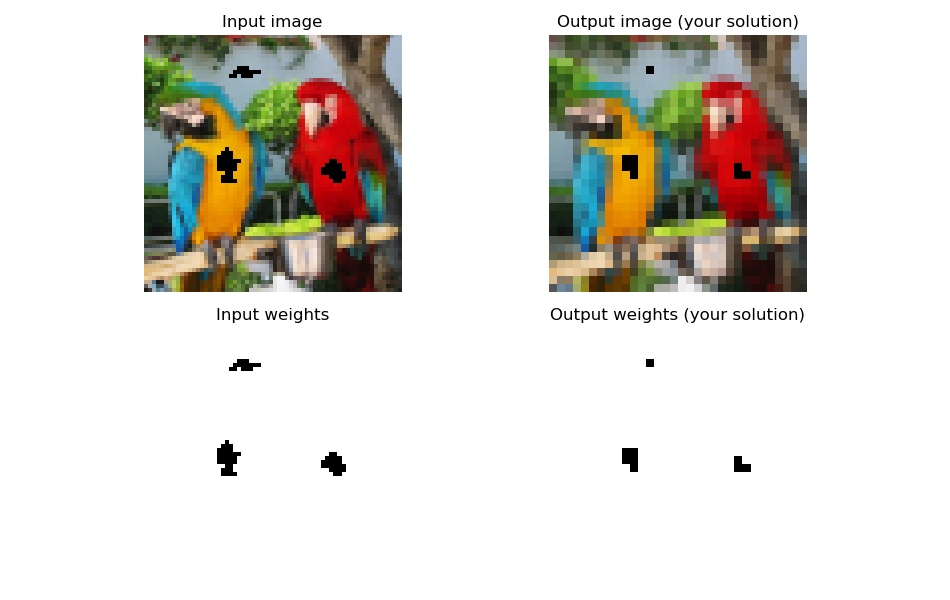

In [3]:
def pull_next_level(image, weights):
    # Prepare ouput.
    im_next = np.zeros((image.shape[0] // 2, image.shape[1] // 2, image.shape[2]), dtype=image.dtype)
    weights_next = np.zeros((image.shape[0] // 2, image.shape[1] // 2), dtype=weights.dtype)
    # TODO: Downscale image to im_next and weights to weights_next as per the exercise description.
    next_size = im_next.shape[0]
    for y_next in range(0, next_size):
        for x_next in range(0, next_size):
            y_image = 2 * y_next
            x_image = 2 * x_next
            im_chunck = image[y_image: y_image + 2, x_image: x_image + 2]
            weight_chunck = weights[y_image: y_image + 2, x_image: x_image + 2]
            valid_pixels = np.sum(weight_chunck)
            if valid_pixels > 0:
                weights_next[y_next, x_next] = 1
                for chanel in range(3):
                    im_next[y_next, x_next, chanel] = np.sum(im_chunck[:,:, chanel]) / valid_pixels
            else:
                weights_next[y_next, x_next] = 0
    return (im_next,  weights_next)
    
image = helpers.imread_normalized_float(os.path.join(local_data_folder, "pyramid", "im_02.png"))
weights = helpers.imread_normalized_float_grayscale(os.path.join(local_data_folder, "pyramid", "w_02.png"))
image[weights == 0] = 0

im_next, weights_next = pull_next_level(image, weights)

helpers.show_images({
    "Input image": image, 
    "Output image (your solution)": im_next,
    "Input weights": weights, 
    "Output weights (your solution)": weights_next
}, nrows=2, ncols=2)        

### Testing your solution of exercise 4
Verify by hand whether you think your solution to exercise 4 is correct. For example: use your mouse to hover over the input image and write down some pixel values in a small region. Work out the expected output by hand and compare it with what your function produces.

In [4]:
# Add your own tests here

In [5]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL


## Excercise 5 (2 points)
Repeat the pull step to build the entire image pyramid. 
Return a tuple with two lists: images and weight maps, both lists should be sorted from the largest (= the input) to the smallest.
Note, that the last level of the pyramid will be a single pixel image $\mathbf{I}^N \in \mathcal{R}^{1 \times 1 \times 3}$ and that $\mathbf{M}^N = 1$. You can again assume that the input is a square image with sides divisible by two.

**NOTE**: For grading we use the reference implementation of `pull_next_level()` to ensure that you are not punished for mistakes in the previous exercises.

Your solution:


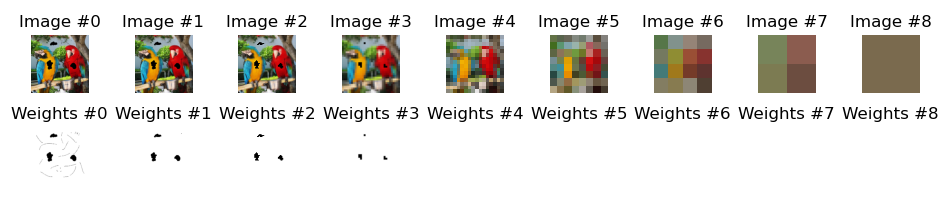

In [6]:
def build_pyramid(image, weights):
    pyramid_im = [image]
    pyramid_w = [weights]
    # TODO: Construct the image- and weights pyramids.
    while pyramid_im[-1].shape[0] > 1:
        last_image = pyramid_im[-1]
        last_weights = pyramid_w[-1]
        next_im,  next_w = pull_next_level(last_image, last_weights)
        pyramid_im.append(next_im)
        pyramid_w.append(next_w)
    return pyramid_im, pyramid_w


image = helpers.imread_normalized_float(os.path.join(local_data_folder, "parrots_256.jpg"))
weights = (helpers.imread_normalized_float_grayscale(os.path.join(local_data_folder, "parrots_mask_256.png")) > 0.5).astype(float)
image[weights == 0] = 0

pyramid_im, pyramid_w = build_pyramid(image, weights)

print("Your solution:")
panels = { f"Image #{i}": im for i, im in enumerate(pyramid_im)}
panels.update({ f"Weights #{i}": im for i, im in enumerate(pyramid_w)})
helpers.show_images(panels, nrows=2, ncols=len(pyramid_im), col_height=1)

### Testing your solution of exercise 5
Verify your solution by hand using the same method as in exercise 5. We provide a couple of basic tests to ensure that you return the values in the correct format for the grading tests.

In [7]:
# Add your own tests here

In [8]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL

import warnings
image = np.ones((128, 128, 3))
weights = np.zeros((128, 128))
weights[62:64, 64:67] = 0
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    image_pyramid, weights_pyramid = build_pyramid(image, weights)
assert(len(image_pyramid) == 8) # 128, 64, 32, 16, 8, 4, 2, 1
assert(image_pyramid[1].shape == (64, 64, 3))
assert(len(weights_pyramid) == 8) # 128, 64, 32, 16, 8, 4, 2, 1
assert(weights_pyramid[1].shape == (64, 64))


## Exercise 6 (4 points)
The push phase of the algorithm fills the missing pixels $\mathbf{x}$ in the (larger) lower pyramid level $\mathbf{I}^{i}$ by bilinear interpolation of the 4 nearest pixels in (smaller) pyramid level $\mathbf{I}^{i+1}$ above.

We first need to find the 4 nearest pixels $A, B, C, D$ which we interpolate to fill the pixel $\mathbf{x}$.

Below you can see how the small pixels in $\mathbf{I^i}$ (thin blue lines) overlap with large pixels $A,B,C,D$ in $\mathbf{I^{i+1}}$ (thick black lines):

<img src="push_grid3.png" alt="Interpolation grid" style="width: 400px;"/>

While pixels are visualized as square patches, for the interpolation it is important to define their exact location. This is typically done by assigning the pixel color to the center of each pixel (see the circles). We can then compute exact position of any point within the pixel grid with subpixel accuracy.

### Example
In the image above, the point $\mathbf{x}^{i} = [2.5, 1.5]$ lies in the center of a pixel $\mathbf{u}^{i} = [2, 1]$ in the high-resolution image $\mathbf{I}^{i}$. The same point projected to the low-resolution image $\mathbf{I}^{i+1}$ will have subpixel coordinates $\mathbf{x}^{i+1} = [1.25, 0.75]$.

The point lies within a $2 \times 2$ neighborhood defined by the centers of pixels A, B, C, D. Subtracting the position of $D$'s center we get a normalized position of the point as $\mathbf{x}^{i+1}_{norm} = [0.75, 0.25]$ which can then be used for bilinear interpolation.

### Task
For a given pixel $\mathbf{u}^{i}$ of the high-resolution image $\mathbf{I}^{i}$ (yellow pixel in the Figure) and its center  $\mathbf{x}^{i}$, find the 4 nearest pixels in $\mathbf{I}^{i+1}$ (see $A, B, C, D$ in the Figure). Return the integer index of the left-top pixel (see $D$) and the relative subpixel position $\mathbf{x}^{i+1}_{norm}$ within the 4 neighboring points. 

Note, that knowledge of the image size or content is not required for this exercise.
Assume that the image is infinite, i.e., both positive and negative coordinates are allowed.

In [129]:
def project_point_up(px_coordinate_in_down):
    pyl, pxl = px_coordinate_in_down
    pxu = (pxl - 1) // 2
    if pxu < 0:
        pxu = 0
    pyu = (pyl - 1) // 2
    if pyu < 0:
        pyu = 0
    index_start =  pyu, pxu
    if pxl % 2 == 0:
         alpha = 0.75
    else:
         alpha = 0.25
    if pyl % 2 == 0:
         beta = 0.75
    else:
         beta = 0.25
    relative_subpixel_position = alpha, beta
    # # Scale down the coordinates to the lower-resolution grid
    # projected_coordinate = [(px_coordinate_in_down[0] + 0.5)/ 2.0, (px_coordinate_in_down[1] + 0.5)/ 2.0]
    # # Integer index of the top-left pixel in the lower-resolution image
    # index_start = np.floor(projected_coordinate).astype(int)
    # # Relative subpixel position within the 2x2 block
    # relative_subpixel_position = [projected_coordinate[0] - (index_start[0] + 0.5), projected_coordinate[1] - (index_start[1] + 0.5)]
    
    return index_start, relative_subpixel_position

### Testing your solution of exercise 6
Try to come up with more inputs and work them out by hand. Does your solution produce the correct result for these cases?

In [130]:
# Add your own tests here
index_start, relative_subpixel_position = project_point_up(np.array([3, 1]))
print("Input point [3, 1]")
print(f"The nearest left-top pixel in the smaller image is {index_start}.")
print(f"The normalized position is {relative_subpixel_position}.")
print("The correct answer should be [1, 0] and [0.25, 0.25]")

Input point [3, 1]
The nearest left-top pixel in the smaller image is (1, 0).
The normalized position is (0.25, 0.25).
The correct answer should be [1, 0] and [0.25, 0.25]


In [127]:
index_start, relative_subpixel_position = project_point_up(np.array([1, 5]))
print("Input point [3, 1]")
print(f"The nearest left-top pixel in the smaller image is {index_start}.")
print(f"The normalized position is {relative_subpixel_position}.")
print("The correct answer should be [0, 1] and [0.25, 0.25]")

Input point [3, 1]
The nearest left-top pixel in the smaller image is [0 2].
The normalized position is [0.25, 0.25].
The correct answer should be [0, 1] and [0.25, 0.25]


In [12]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL


## Exercise 7 (2 points)
Next, we need to combine the colors from the 4 nearest pixels using bilinear interpolation.

Given the 4 nearest pixel color values $\{\mathbf{I}^{i}(\mathbf{A}), \mathbf{I}^{i}(\mathbf{B}), \mathbf{I}^{i}(\mathbf{C}), \mathbf{I}^{i}(\mathbf{D})\} \in \mathcal{R}^{4\times3}$ and a normalized point position $\mathbf{x} = (\alpha, \beta) \in [0,1]\times[0,1]$, compute interpolated value using bilinear interpolation.

<img src="bilinterp.png" alt="Interpolation grid" style="width: 400px;"/>

Bilinear interpolation is a weighted mean of 4 corner values with weights proportional to areas of rectangle adjacent to each of the source vertices. It can also be separated into 3 one-dimensional linear interpolations by first interpolating the the between $A$ and $B$, and $D$ and $C$ using $\alpha$ and then interpolating the intermediate results in an orthogonal dimension defined by $\beta$.

In [128]:
def bilinear_interpolation(col_a, col_b, col_c, col_d, x):
    # TODO: Implement bilinear interpolation between a, b, c, d as shown in the image above. x stores (alpha, beta)
    alpha, beta = x
    col = col_c * alpha * (1 - beta) + col_b * alpha * beta + col_a * beta * (1-alpha) + col_d * (1 - beta) * (1 - alpha)
    return col

a = np.array([1.0, 1.0, 1.0])
b = np.array([0, 0.0, 1.0])
c = np.array([0, 1.0, 0])
d = np.array([1.0, 0, 0])
x = np.array([0.75, 0.75])

interpolated = bilinear_interpolation(a,b,c,d,x)

print(f'The interpolated color at {x} was computed as {np.array2string(interpolated, precision=3)}')

The interpolated color at [0.75 0.75] was computed as [0.25  0.375 0.75 ]


### Testing your solution of exercise 7
Try to come up with more inputs and work them out by hand. Does your solution produce the correct result for these cases?

In [87]:
col_a = 0.15
col_b = 0.23
col_c = 0.4
col_d = 0.83
x = 0.25, 0.25
print(bilinear_interpolation(col_a, col_b, col_c, col_d, x))

0.584375


In [15]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL


## Exercise 8 (4 points)

Now we can combine Excercise 6 and 7 together and implement an entire push phase. 

Implement a method that collapses the image pyramid $\mathbf{I}^{0..N}$ in the up-down direction and fills missing pixels in each larger high-resolution image $\mathbf{I}^{i}$ by interpolating a corresponding low-resolution image $\mathbf{I}^{i+1}$.
Do not modify pixels that are marked as valid in the provided weights map $M^{i}$.

### Notes
Visit every level of the pyramid from the top to the bottom.
Test every output pixel and update values of those pixels that are not yet valid. 
For each such pixel find the 4 neighboring low-resolution pixels and relative pixel position using the code from Exercise 6.
Use the relative position as bilinear interpolation weights.
Take a special care for pixels that lie close to the image boundary as one of the four neighbors can lie outside of $\mathbf{I}^{i+1}$. Clamp the coordinates of such neighbor pixel to the domain on $\mathbf{I}^{i+1}$.

**Tip**: look at the image of exercise 7 and how the subpixel coordinates relate to $\alpha$ and $\beta$!

For grading we use the reference implementation of `project_point_up()` and `bilinear_interpolation` to ensure that you are not punished for mistakes in the previous exercises.

Your solution:


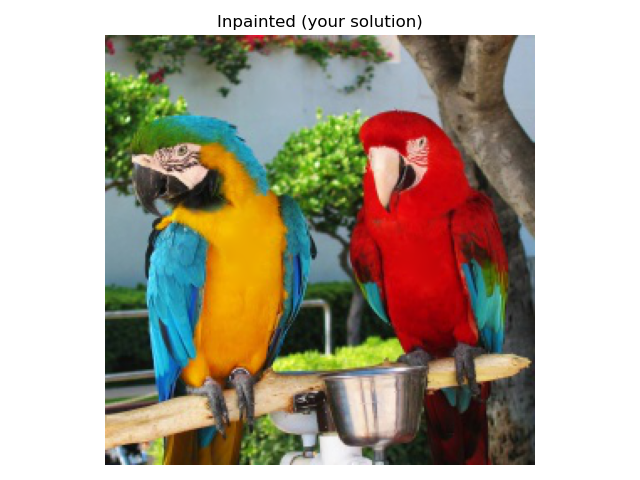

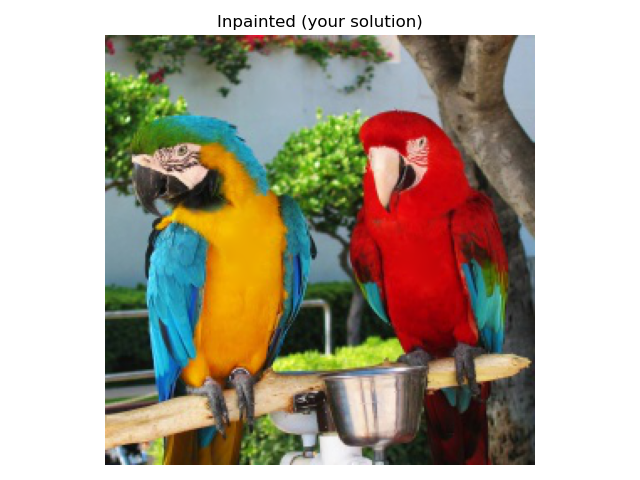

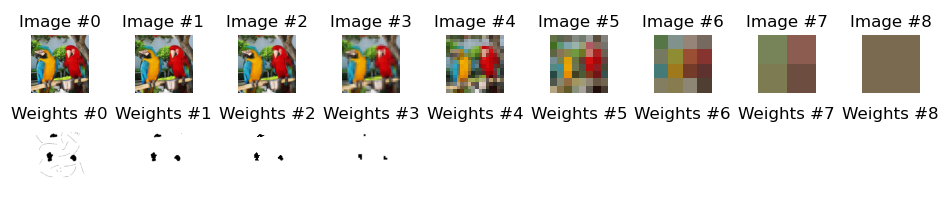

In [133]:
def push_pyramid(im_pyramid, w_pyramid):
    # TODO: Interpolate im_pyramid[i+1] to fill im_pyramid[i] where w_down == 0.
    #       Modify im_pyramid in-place (do not edit a copy); this function should **not** return anything.
    for i in range(len(im_pyramid) - 1, 0, -1):
        up_im = im_pyramid[i]
        #up_w = w_pyramid[i]
        down_im = im_pyramid[i - 1]
        down_w = w_pyramid[i - 1]
        for y in range(down_im.shape[0]):
            for x in range(down_im.shape[1]):
                if down_w[y, x] == 0:
                    xmin = 0
                    ymin = 0
                    xmax = up_im.shape[1] - 1
                    ymax = up_im.shape[0] - 1
                    
                    index_start, relative_subpixel_position = project_point_up(np.array([y, x]))
                    pos_A = np.array([index_start[0] + 1, index_start[1]])
                    pos_B = np.array([index_start[0] + 1, index_start[1] + 1])
                    pos_C = np.array([index_start[0], index_start[1] + 1])
                    pos_D = np.array(index_start)

                    clamped_A = np.clip(pos_A, [xmin, ymin], [xmax, ymax])
                    clamped_B = np.clip(pos_B, [xmin, ymin], [xmax, ymax])
                    clamped_C = np.clip(pos_C, [xmin, ymin], [xmax, ymax])
                    clamped_D = np.clip(pos_D, [xmin, ymin], [xmax, ymax])

                    col_a = up_im[clamped_A[0], clamped_A[1]]
                    col_b = up_im[clamped_B[0], clamped_B[1]]
                    col_c = up_im[clamped_C[0], clamped_C[1]]
                    col_d = up_im[clamped_D[0], clamped_D[1]]
                    
                    col = bilinear_interpolation(col_a, col_b, col_c, col_d, relative_subpixel_position)
                    im_pyramid[i - 1][y, x] = col
                    
                    

im_files = sorted(helpers.list_files_in_folder(os.path.join(local_data_folder, 'pyramid'), filter="im_*.png"))
im_pyramid = [helpers.imread_normalized_float(f) for f in im_files]
w_files = sorted(helpers.list_files_in_folder(os.path.join(local_data_folder, 'pyramid'), filter="w_*.png"))
w_pyramid = [helpers.imread_normalized_float_grayscale(f) for f in w_files]
push_pyramid(im_pyramid, w_pyramid)

print("Your solution:")
helpers.show_image(im_pyramid[0], title="Inpainted (your solution)")
panels = { f"Image #{i}": im for i, im in enumerate(im_pyramid)}
panels.update({ f"Weights #{i}": im for i, im in enumerate(w_pyramid)})
helpers.show_images(panels, nrows=2, ncols=len(im_pyramid), col_height=1)

### Testing your solution of exercise 8
The image pyramid should now not contain any holes anymore. Verify that the interpolated values are correct by creating a simple test case (e.g. 4x4 image that you create yourself) and verify that bilinear interpolation is working correctly.

In [17]:
# Add your own tests here

In [18]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL


## Full Algorithm
Now we have all the necessary components of a complete Pull-Push algorithm and we can use it for image inpainting.
In this example we will remove red text caption that has been embedded into a photograph.

We recommend you to also try other images and masks. Can you come up with an example where the Pull/Push algorithm doesn't work as well?

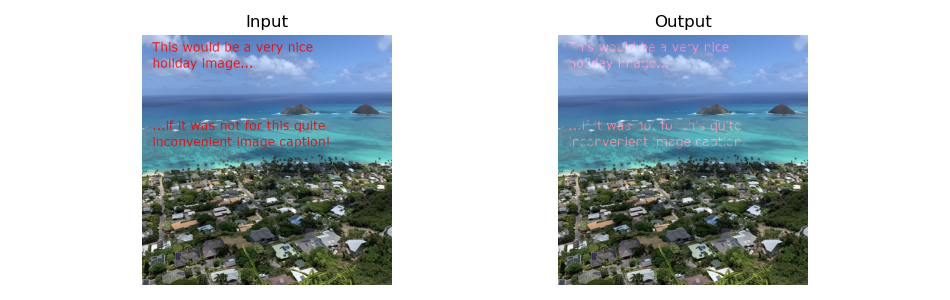

In [132]:
def remove_red_text(image):
    # Detect text.
    weights = 1 - np.all(image == [[[1, 0, 0]]], axis=-1)   
    # 1. Pull
    p_im, p_w = build_pyramid(image, weights)
    # 2. Push
    push_pyramid(p_im, p_w)
    return p_im[0]


image = helpers.imread_normalized_float(os.path.join(local_data_folder, "image_with_text.png"))
clean_image = remove_red_text(image.copy())

panels = { f"Output #{i}": im for i, im in enumerate(pyramid_im)}
helpers.show_images({
    'Input': image,
    'Output': clean_image
}, nrows=1, ncols=2)

# Extra Exercises (Patch Based Inpainting)
The previous exercises are enough to get you a passing grade. However, to get a $10$ you need to show that you have mastered the topic. Therefore, we introduce the following extra exercises which are considered a bit more challenging. You need to complete these without the help of the teaching assistants (TAs). **You not allowed to ask the TAs for help with the extra exercises**. However, you can report bugs by sending us an e-mail at `vdp-cs-ewi@tudelft.nl`.

With pull-push you have implemented an inpainting technique based on low-level statistics. In the following extra exercises you will implement (a part of) the patch based inpainting technique from the paper [Region filling and object removal by exemplar-based image inpainting](https://www.irisa.fr/vista/Papers/2004_ip_criminisi.pdf) which was also described in class. The idea is to take patches (small square regions) from the known image and paste them into the missing pixels. The challenge is to find the most suitable patch and to fill pixels in an appropriate order.

<img src="images/canyonlakedrive.jpg" alt="Hollywood Sign" style="height: 25em;"/>

### Selecting the next patch to fill
We are given an image $J$ with unknown pixels defined by a second mask image, similar to the previous exercises (with $1$ for known pixels and $0$ for unknown pixels). To select the next region to inpaint we consider the unknown pixels on the boundary between the known/unknown regions of the image. For each of those pixels we consider filling the patch centered at that pixel. We select the patch to fill by maximizing the following equation:

$$P(p) = C(p) * D(p)$$

The data term $D(p)$ prefers selecting patches such that edges or lines in the image are inpainted first, before inpainting more flat/uniform regions. The data term is defined as the length of the projection of the isophote (edge/line in the image) and the normal vector of the inpainting boundary. The isophote is orthogonal to the gradient with the highest magnitude between known pixels in the patch. The normal vector of the known/unknown region boundary is computed by taking the difference between the current boundary pixel and the next boundary pixel.

<img src="images/data_term.png" alt="Data Term" style="height: 25em;"/>

When inpainting we continuously select a patch on the boundary of the unknown region, fill it by copy & pasting values from another patch, and continue untill the whole image is filled. We cannot be sure however that the colours that we picked to fill preceding patches accurately represent what was supposed to be there. Therefore, our confidence in the value of those pixels, and thus the data term, drops. This confidence in each pixel's value at step $k$ is stored in a confidence image $C_k(q)$ which, like the image mask, starts as $C_0(q)$ with $1.0$ for all known pixels (100% confident) and $0.0$ for unknown pixels. The confidence value $C_k(p)$ is defined as the mean $C_{k-1}(q)$ value for all pixels inside the patch. When a patch centered at pixel $p$ is selected for inpainting in step $k$, the confidence values $C_k(q)$ of unknown pixels in the patch are updated to the confidence value $C_{k-1}(p)$ from the previous step.

<img src="images/confidence_term.png" alt="Confidence Term" style="height: 25em;"/>


### Exercise 9 (1 point)
You will implement a function that computes the confidence term $C_k(p)$ for a given patch as described above (and in the lecture). Your function takes the confidence image $C_{k-1}(p)$, the pixel at the center of the patch, and the patch size. You can use the helper function `slice_patch` to get the patch from an image. You do not need to handle patches that lie (partially) outside the image; we guarantee that no such patches will be provided.

In [20]:
# DO NOT MODIFY THIS CELL
def slice_patch(image, x, y, patch_size):
    half_patch_size = patch_size // 2
    return image[y-half_patch_size:y+half_patch_size+1, x-half_patch_size:x+half_patch_size+1]

In [97]:
def compute_confidence_term(confidence_image, x, y, patch_size):
    # TODO: Compute the confidence term of the image patch with the given size and centered at (x, y)
    half_patch_size = patch_size // 2
    return np.mean(confidence_image[y-half_patch_size:y+half_patch_size+1, x-half_patch_size:x+half_patch_size+1])

### Testing your solution of exercise 9
Try to come up with some test cases (e.g. images) to ensure your solution is working as expected.

In [22]:
# Add your own tests here.

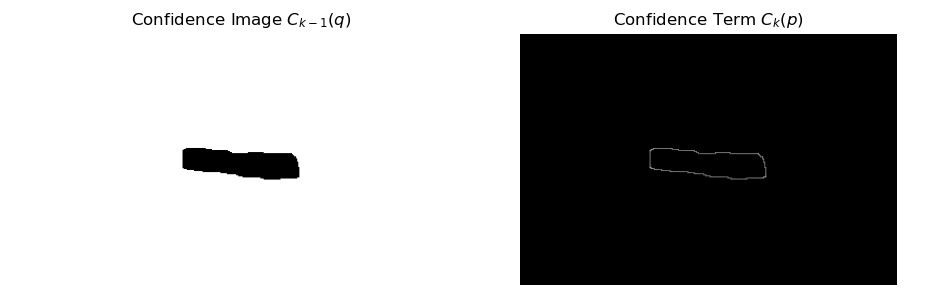

In [98]:
image = helpers.imread_normalized_float(os.path.join(local_data_folder, "canyonlakedrive.jpg"), 0.35)
mask = (helpers.imread_normalized_float_grayscale(os.path.join(local_data_folder, "canyonlakedrive_mask.png"), 0.35) < 0.5)
image[mask == 0] = 0

# Compute boundary pixels
confidence_image_cq = mask.copy()
confidence_term_cp = np.zeros(mask.shape)
patch_size = 9
for y, x in zip(*np.where(mask == 0)):
    if np.sum(image[y-1:y+2,x-1:x+2]) > 0:
        confidence_term_cp[y, x] = compute_confidence_term(confidence_image_cq, x, y, patch_size)

helpers.show_images({
    'Confidence Image $C_{k-1}(q)$': mask,
    'Confidence Term $C_k(p)$': confidence_term_cp
}, nrows=1, ncols=2)

In [24]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL


### Fill Front
In order to compute the data term $D(p)$ we need to define the normal vector of the boundary. This is computed by comparing the current boundary pixel position to its neighbours positions. The following provided code computes the list of pixels on the boundary of the known/unknown region in clock wise order.

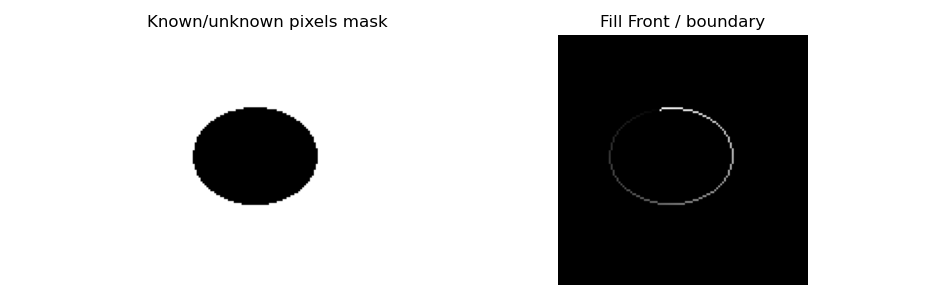

In [99]:
# Find all boundary pixels (fill front) in clock wise order (must be sorted to compute data term)
def compute_fill_front(target_mask):
    # If there are no pixels to fill then we are done.
    if np.sum(1 - target_mask) == 0:
        return []
    
    # We need to find a starting point. We find an unknown pixel which might be a boundary pixel but could also lie deeper in the unknown region.
    # So we visit all pixels in that row (same y coordinate) from left to right to find the first boundary pixel.
    first_y, _ = next(zip(*np.where(target_mask == 0)))
    for first_x in range(target_mask.shape[1]):
        if target_mask[first_y, first_x] == 0:
            break
    
    fill_front = [] # Sorted output
    visited_pixels = set() # Contains the currently visited set of pixels (same as fill front but a set() instead of list() for faster lookups)
    
    # The potential neighbours to consider (relative to the current pixel) in *clockwise* order.
    directions = [(-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0)]
    current_direction = 0 # Current direction that we are following along the boundary
    x, y = first_x, first_y # x and y coordinates of the current boundary pixel
    done = False # Track whether we are done (finished the circle)
    while not done:
        # Add the current boundary pixel to the output
        fill_front.append((x, y))
        visited_pixels.add((x, y))
        
        # Start by trying to go backwards (current_direction + 4) and from there visit the neighbours in clockwise order.
        done = True
        direction = current_direction + 4
        for i in range(len(directions)):
            dx, dy = directions[(direction + i) % len(directions)]
            nx, ny = x + dx, y + dy
            # A pixel is a boundary pixel if its value is unknown and at least one of its (8 connected) neighbours is known.
            is_neighbour_on_boundary = np.sum(target_mask[ny-1:ny+2,nx-1:nx+2]) > 0 and target_mask[ny, nx] == 0
            if is_neighbour_on_boundary and (nx, ny) not in visited_pixels: # Skip neighbours that we've already visited
                x, y = nx, ny # Visit the neighbour
                current_direction = (direction + i) % len(directions)
                done = False # We visited a new neighbour so we are not done yet
                break # Stop the clockwise visiting and go to the neighbour we just selected
    
    return fill_front


mask = (helpers.imread_normalized_float_grayscale(os.path.join(local_data_folder, "line_mask.png"), 1) > 0.5)
fill_front = compute_fill_front(mask)

image = np.zeros(mask.shape)
for i, (x, y) in enumerate(fill_front):
    image[y, x] = i / len(fill_front)

helpers.show_images({
    "Known/unknown pixels mask": mask,
    "Fill Front / boundary": image
}, nrows=1, ncols=2)

### Exercise 10 (4 points)
Complete the given function which takes a list of pixels along the fill front (to compute the normal) and computes for each of those pixels the data term $D(p)$. Refer to the description above the previous exercise, or the lecture slides, for more information on how to compute the data term.

*Tip*: remember that the isophote is parallel to an edge and not orthognal like a gradient.

In [121]:
def normalize(v):
    return np.array(v) / np.linalg.norm(v)

def compute_data_term_along_fill_front(image, target_mask, patch_size, fill_front):
    gray_image = helpers.rgb2gray(image)    
    gradient_x = scipy.signal.correlate2d(gray_image, [[-0.5, 0, +0.5]], mode="same", boundary="symm")
    gradient_y = scipy.signal.correlate2d(gray_image, [[-0.5], [0], [+0.5]], mode="same", boundary="symm")
    
    # Mask out pixels for which a neighbour is unknown (and thus the gradient is invalid)
    grown_mask = 1 - (scipy.signal.correlate2d(1-target_mask, [[0,1,0], [1,0,1],[0,1,0]], mode="same") > 0)
    gradient_x *= grown_mask
    gradient_y *= grown_mask
    
    out = []
    for (xl, yl), (x, y), (xr, yr) in zip(fill_front[-1:] + fill_front[:-1], fill_front, fill_front[1:] + fill_front[:1]):
        # Normal of the boundary.
        n_p = normalize([yl-yr, xr-xl]) # (xr-xl, yr-yl) is parallel to the boundary; (-(yr-yl), xr-xl) is orthogonal to the boundary.
    
        # ======================
        # === ADD CODE BELOW ===
        # ======================
        # For the patch of patch_size around the pixel (x, y) (as returned by the slice_patch() method),
        #  compute the isophote using the highest magnitude gradient within the patch (according to the L2 norm).
        # Remember that the isophote is not the gradient itself, but orthognal to the gradient.
        # Use the isophote and normal of the boundary (computed above) to compute the data term D(p) and store the result in the variable "D_p".
        D_p = 0.0
        # YOUR CODE HERE
        half_patch_size = patch_size // 2
        max_gradient_magnitude = 0
        direction_m = None
        for x_patch in range(x-half_patch_size, x+half_patch_size+1):
            for y_patch in range(y-half_patch_size, y+half_patch_size+1):
                gradient_magnitude = (gradient_x[y_patch, x_patch]**2 + gradient_y[y_patch, x_patch]**2)**0.5
                direction = gradient_y[y_patch, x_patch], gradient_x[y_patch, x_patch]
                if gradient_magnitude > max_gradient_magnitude:
                    direction_m = direction
                    max_gradient_magnitude = gradient_magnitude
        isophote = -direction_m[1], direction_m[0]
        
        out.append(D_p)

    return out

### Testing your solution of exercise 10
The following code displays the data term for the whole image. The data term values are multiplied by three to increase visibility. Try to come up with some additional test cases (images) to convince yourself that your solution is working as expected.

In [27]:
# Add your own tests here.

(0.18690980225801468, 0.002407841384410858)
(0.1440706104040146, 0.07860785722732544)
(0.1440706104040146, 0.07860785722732544)
(0.08115685731172562, 0.12349804490804672)
(0.10035098344087601, 0.07575489580631256)
(-0.11788039654493332, -0.018684320151805878)
(0.1336294189095497, -0.04165881872177124)
(0.1336294189095497, -0.04165881872177124)
(0.1336294189095497, -0.04165881872177124)
(0.1336294189095497, -0.04165881872177124)
(0.1336294189095497, -0.04165881872177124)
(0.1336294189095497, -0.04165881872177124)
(0.1336294189095497, -0.04165881872177124)
(0.1336294189095497, -0.04165881872177124)
(0.1336294189095497, -0.04165881872177124)
(0.12874705344438553, 0.017188236117362976)
(0.12874705344438553, 0.017188236117362976)
(0.12874705344438553, 0.017188236117362976)
(0.12874705344438553, 0.017188236117362976)
(0.12874705344438553, 0.017188236117362976)
(0.1265607848763466, -0.01322745531797409)
(0.1265607848763466, -0.01322745531797409)
(0.1265607848763466, -0.01322745531797409)
(0.1

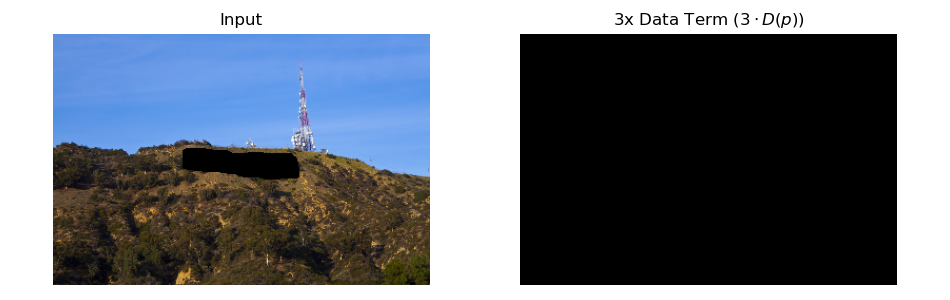

In [122]:
image = helpers.imread_normalized_float(os.path.join(local_data_folder, "canyonlakedrive.jpg"), 0.35)
mask = (helpers.imread_normalized_float_grayscale(os.path.join(local_data_folder, "canyonlakedrive_mask.png"), 0.35) < 0.5)
image[mask == 0] = 0

patch_size = 9

fill_front = compute_fill_front(mask)
fill_front = [(x, y) for x, y in fill_front if x > 3 and y > 3]
data_term_on_fill_front = compute_data_term_along_fill_front(image, mask, patch_size, fill_front)

# Create an image showing the value of D(p) along the fill front / boundary
data_term_image = np.zeros(mask.shape)
for (x, y), D_p in zip(fill_front, data_term_on_fill_front):
    data_term_image[y, x] = D_p

helpers.show_images({
    'Input': image,
    '3x Data Term ($3 \cdot D(p)$)': data_term_image * 3
}, nrows=1, ncols=2)

In [29]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL


### Finding a matching patch
Once a *query* patch has been selected for inpainting (using product of the confidence & data terms) we now need to find new values to assign to the unknown pixels inside the query patch. The algorithm is based on the idea of copy & pasting patches from other (known) parts of the image. All *complete* patches (patches fully inside the image with no unknown pixels) are visited and compared to the *query* patch and the most similar one is selected.

Similarity between a *query* patch and the complete patches is defined the negated sum of squared differences over the *known* pixels. Unknown pixels (that need to be filled in) should be excluded from this sum:
$$
\text{similarity}({query}, {compare}) = -\sum_{i \in \text{known pixels/color channels in query}}{({query}_i - {compare}_i)^2}
$$

### Exercise 11 (4 points)
Implement a function that searches the image for the most similar *complete* patch for the given *query* patch. Return the center pixel of this selected patch.

In [30]:
import matplotlib.patches as patches

def find_most_similar_patch(image, target_mask, query_x, query_y, patch_size):
    x = 10
    y = 10
    # TODO: Iterate over all patches in the image that have only known pixels
    #       Compute the similarity between 
    # YOUR CODE HERE
    return (x, y)

### Testing your solution of exercise 11
The following code displays a query patch and the most similar patch as found by your implementation. Try to come up with some additional test cases (patches) to convince yourself that your solution is working as expected.

In [31]:
# Add your own tests here.

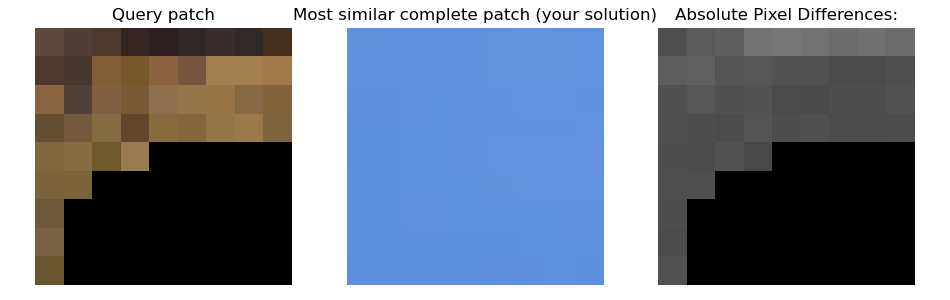

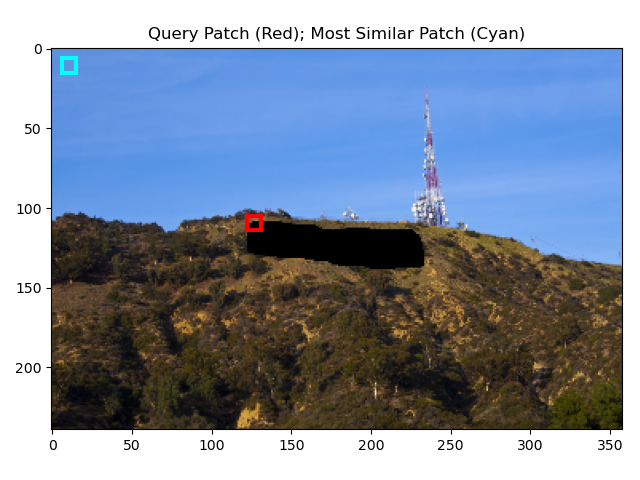

In [32]:
image = helpers.imread_normalized_float(os.path.join(local_data_folder, "canyonlakedrive.jpg"), 0.35)
mask = (helpers.imread_normalized_float_grayscale(os.path.join(local_data_folder, "canyonlakedrive_mask.png"), 0.35) < 0.5)
image[mask == 0] = 0

patch_size = 9
half_patch_size = patch_size // 2

query_pixels = list(zip(*np.where(mask == 0)))
query_y, query_x = query_pixels[0] # TRY OUT DIFFERENT QUERY PIXELS BY CHANGING THIS NUMBER
match_x, match_y = find_most_similar_patch(image, mask, query_x, query_y, patch_size)

helpers.show_images({
    "Query patch": slice_patch(image, query_x, query_y, patch_size),
    "Most similar complete patch (your solution)": slice_patch(image, match_x, match_y, patch_size),
    "Absolute Pixel Differences:": slice_patch(mask, query_x, query_y, patch_size) * np.mean(np.abs(slice_patch(image, query_x, query_y, patch_size) - slice_patch(image, match_x, match_y, patch_size)), axis=2)
}, ncols=3, nrows=1)

fig, ax1 = plt.subplots(1, 1)
ax1.set_title("Query Patch (Red); Most Similar Patch (Cyan)")
ax1.imshow(image)
ax1.add_patch(patches.Rectangle((query_x - half_patch_size, query_y - half_patch_size), patch_size, patch_size, fill=False, edgecolor="red", linewidth=3))
ax1.add_patch(patches.Rectangle((match_x - half_patch_size, match_y - half_patch_size), patch_size, patch_size, fill=False, edgecolor="cyan", linewidth=3))
fig.tight_layout()

In [33]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL


### Inpainting
With the exercises implemented it is now possible to run the complete inpainting algorithm. In a continuous loop the highest priority patch is selected (exercises 9 & 10), the most similar complete image patch is found (exercise 11) and values from that patch are pasted into the unknown pixels of the selected query patch. Finally the unknown pixels in the confidence image $C_k(p)$ is updated from the value of $C_{k-1}(p)$.

The full inpainting algorithm is implemented below and should succesfully remove the Hollywood sign from Mount Lee. The inpainting process is visualized interactively: the image is updated after each step. Don't worry if it takes a couple minutes to perform the inpainting; this is not part of the grading tests.

In [34]:
import progressbar
from IPython import display
import os

def select_highest_priority_patch(image, confidence_image, target_mask, fill_front, patch_size):
    confidence_term = [compute_confidence_term(confidence_image, x, y, patch_size) for x, y in fill_front]
    data_term = compute_data_term_along_fill_front(image, target_mask, patch_size, fill_front)
    priority = np.array(confidence_term) * np.array(data_term)
    selected_index = np.argmax(priority)
    return (fill_front[selected_index], confidence_term[selected_index])

def patch_based_inpainting(image, target_mask, patch_size):
    confidence_image = np.zeros(target_mask.shape)
    confidence_image[mask == 0] = 1
    
    fig, ax = plt.subplots(1,1)
    fig.show()
    
    num_pixels_to_fill = np.sum(1 - target_mask)
    image = image.copy()
    with progressbar.ProgressBar(maxval = num_pixels_to_fill) as bar:
    #with progressbar.ProgressBar(max_value = num_pixels_to_fill) as bar:
        while True:
            bar.update(num_pixels_to_fill - np.sum(1 - target_mask)) # Number of pixels that have not been filled yet.
            fill_front = compute_fill_front(target_mask)
            if not fill_front:
                break

            (x, y), confidence = select_highest_priority_patch(image, confidence_image, target_mask, fill_front, patch_size+4)
            qx, qy  = find_most_similar_patch(image, target_mask, x, y, patch_size)
            mask_patch = slice_patch(target_mask, x, y, patch_size)
            out_patch = slice_patch(image, x, y, patch_size)
            in_patch = slice_patch(image, qx, qy, patch_size)
            for dy in range(patch_size):
                for dx in range(patch_size):
                    if mask_patch[dy, dx] == 0:
                        out_patch[dy, dx, :] = in_patch[dy, dx, :]
            slice_patch(confidence_image, x, y, patch_size)[:] = confidence
            mask_patch[:] = 1 # Set the mask to 1 pixels in the patch

            ax.imshow(image, interpolation="None")
            display.clear_output(wait=True)
            display.display(fig)
        
    return image


image = helpers.imread_normalized_float(os.path.join(local_data_folder, "canyonlakedrive.jpg"), 0.35)
mask = (helpers.imread_normalized_float_grayscale(os.path.join(local_data_folder, "canyonlakedrive_mask.png"), 0.35) < 0.5)
original_image = image.copy()
image[mask == 0] = 0
# Don't execute the inpainting algorithm when grading
if os.environ.get("NBGRADER_EXECUTION") != "autograde" and os.environ.get("NBGRADER_EXECUTION") != "validate":
    clean_image = patch_based_inpainting(image, mask, 9)

helpers.show_images({
    'Input': original_image,
    'Output': clean_image
}, nrows=1, ncols=2)

ModuleNotFoundError: No module named 'progressbar'